<!-- dom:TITLE: Programmation Python  pour les mathématiques -->
# Python Programming for Mathematics
<!-- dom:AUTHOR: Julien Guillod at [Sorbonne Université](http://www.sorbonne-universite.fr/), -->
<!-- Author: -->  
**Julien Guillod**, [Sorbonne Université](http://www.sorbonne-universite.fr/),
Licensed <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">CC BY-NC-ND</a>


All chapters are available in
[HTML](https://python.guillod.org//) and [PDF](https://python.guillod.org//python.pdf).
This notebook is also executed on [mybinder](https://mybinder.org/v2/gh/juguillod/python/master?filepath=chap07.ipynb).






# 7 Solving equations
<div id="ch:newton"></div>

The goal of this exercise is to approach zeros of a function by using Newton's method. This allows in particular finding the approached solutions of non-linear equations. This method is as fundamental in terms of numerical approaches as analitical.

**This chapter covers:**

* Newton's method in one and multiple dimensions

* Jacobian's matrix

* Attractors from Newton's method

* Fractal set

* Optimisation by parallelisation

* Non-linear differential equation

* Finite differences





<!-- --- begin exercise --- -->

# Exercise 7.1: Newton's method in one dimension

In one dimension, the Newton's method looks to find one solution of one single equation. This equation can be expressed under the general form $F(x)=0$ in which $F:\mathbb{R}\to\mathbb{R}$ is a common function, so the goal is to find a zero to this function $F$. The equation $F(x)=0$ is equivalent, if $F' \neq 0$, to another equation $G(x)=x$ in which $G$ is defined by:

$$
G(x) = x - \frac{F(x)}{F^\prime(x)} \,.
$$

The Newton's method looks to find a fixed point of $G$, *i.e.* solving for $G(x)=x$ by consecutive iterations:

$$
x_{i+1} = G(x_i) = x_i - \frac{F(x_i)}{F^\prime(x_i)}
$$

starting from an initial value $x_0\in\mathbb{R}$.

When the sequence $(x_i)_ {i\in\mathbb{N}}$ converges, its limit $x$ is a solution to $G(x)=x$ and to $F(x)=0$.

**a)**
Write a function `newton1d(F, DF, x0, eps=1e-10, N=1000)` which, given a function $F$, its derivative $F'$ and an initial value $x_0$, calculates Newton's iterations until $|F(x_{i})| < \varepsilon$ and returns $x_i$. If a solution cannot be found after $N$ iterations, returns an error.



In [1]:
import numpy as np

def newton1d(F, DF, x0, eps=1e-10, N=1000):
    for i in range(1,N+1):
        xi = x0 - F(x0)/DF(x0)
        if np.abs(F(xi)) < eps:
            return xi
        x0 = xi
    return 'Error!'

F = lambda x: x**3 - 2*(x**2) + x + 5
DF = lambda x: 3*(x**2) - 4*x + 1

x_star = newton1d(F, DF, 10)
F(x_star)

0.0


**b)**
Using the function defined above, find an approached root of the equation $e^{-x}=x$.


<!-- --- begin answer of exercise --- -->
**Answer:**
The answer is approximately $x=0.56714$.

<!-- --- end answer of exercise --- -->



In [2]:
F = lambda x: np.exp(-x) - x
DF = lambda x: -np.exp(-x) - 1

newton1d(F, DF, 1)

0.5671432904097838


**c)**
Without using the function `sqrt` or any fractionnal power methods, define a function `find_root(x,n)` calculating $\sqrt[n]{x}$.

In [3]:
def find_root(x, n, eps=1e-10, N=1000):
    x0 = 1
    
    F = lambda t: t**n - x
    DF = lambda t: n*(t**(n-1))
    
    for i in range(1,N+1):
        xi = x0 - F(x0)/DF(x0)
        if abs(F(xi)) < eps:
            return xi
        x0 = xi
    return 'Error'
    
print(find_root(27, 3))
print(find_root(8, 3))
print(find_root(-5**5, 5))
print(find_root(9, 0.5))

3.0000000000000977
2.0
-5.000000000000005
81.00000000000001


Sometimes, the derivative of $F$ is not known analytically, it is then necessary to approach it numerically:

$$
F^\prime(x_i) \approx \frac{F(x_i) - F(x_{i-1})}{x_i-x_{i-1}}
$$

which arrives at the ___secant method___:

$$
x_{i+1} =  x_i - F(x_i) \frac{x_i-x_{i-1}}{F(x_i) - F(x_{i-1})} = \frac{x_{i-1}F(x_{i})-x_{i}F(x_{i-1})}{F(x_{i})-F(x_{i-1})}
$$

where $x_0$ and $x_1$ must be chosen.

**d)**
Write a function `secant1d(F, x0, x1, eps=1e-10, N=1000)` which implements the secant method then test it using the previous example.

In [4]:
def secant1d(F, x0, x1, eps=1e-10, N=1000):
    xi_m1 = x0
    xi = x1
    
    for i in range(1,N+1):
        xi_p1 = (xi_m1*F(xi) - xi*F(xi_m1)) / (F(xi) - F(xi_m1))
        if abs(F(xi_p1)) < eps:
            return xi_p1
        xi_m1, xi = xi, xi_p1
    return 'Error'

F = lambda x: np.exp(-x) - x
print(secant1d(F, 1, 2))

F = lambda x: x**3 - 2*(x**2) + x + 5
print(secant1d(F, 1, 2))

0.5671432904419066
-1.1163432986242117



<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

# Exercise 7.2: Newton's method in multiple dimensions
<div id="exer:newton-Rn"></div>
The Newton's method in one dimension is easily generalisable to multiple dimensions to solve equations under the form $F(x)=0$ where $F:\mathbb{R}^n \to \mathbb{R}^n$ is a common function. Conceptually, this method is the same as before: the equation $F(x)=0$ is equivalent to $G(x)=x$ in which:

$$
G(\boldsymbol{x}) = \boldsymbol{x} - \big(F^\prime(\boldsymbol{x})\big)^{-1} F(\boldsymbol{x})
$$

where $F'(x)$ represents the Jacobian matrix $n \times n$ of $F$ at $x$.

Then Newton's iterations can be written as:

$$
\boldsymbol{x}_{i+1} = \boldsymbol{x}_{i} - \big(F^\prime(\boldsymbol{x}_i)\big)^{-1} F(\boldsymbol{x}_i)
$$

**a)**
Write a function `newton(F, DF, x0, eps=1e-12, N=10000)` which implements the Newton's method in more than one dimension.

In [5]:
def newton(F, DF, x0, eps=1e-10, N=1000):
    for i in range(1,N+1):
        xi = x0 - np.dot(np.linalg.inv(DF(x0)), F(x0))
        if np.linalg.norm(F(xi)) < eps:
            return xi
        x0 = xi
    return 'Error'

**b)**
Use the above function to solve for the system below:

$$
\begin{align*}
\cos(x) & =\sin(y)\,, & e^{-x} & =\cos(y)\,.
\end{align*}
$$

<!-- --- begin answer of exercise --- -->
**Answer:**
The solution is approximately $x=0.58853$ and $y=0.98226$.

<!-- --- end answer of exercise --- -->



In [6]:
F = lambda X:  np.array([np.cos(X[0]) - np.sin(X[1]), np.exp(-X[0]) - np.cos(X[1])])
DF = lambda X: np.array([
    [-np.sin(X[0]), -np.cos(X[1])],
    [-np.exp(-X[0]), np.sin(X[1])]
])

x0 = np.array([1,1])
newton(F, DF, x0)

array([0.58853274, 0.98226358])



<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

# Exercise 7.3: Attractor of the Newton's method

The goal of this exercise is to solve for the equation $z^3 = 1$ in the complex plane using Newton's method and to analyse the convergence of the method towards one of the three roots according to the choice of the initial point $z_0$.


**a)**
If necessary, rewrite the function `newton1d` so that it also computes complex numbers then test it with different values of $z_0$ to solve for $z^3 = 1$.

In [7]:
def newton1d_new(F, DF, x0, eps=1e-10, N=1000):
    for i in range(1,N+1):
        xi = x0 - F(x0)/DF(x0)
        if np.linalg.norm(F(xi)) < eps:
            return xi
        x0 = xi
    return 'Error!'

F =  lambda z: z**3-1
DF = lambda z: 3*z**2

z = [0.99 + 0.001j, -1j, -1+2j]
for z0 in z:
    print(newton1d_new(F, DF, z0))

(1-7.894656351241113e-17j)
(-0.5-0.8660254037844387j)
(-0.4999999999999309+0.8660254037842952j)



**b)**
For each $z_0 \in \big\{x_0+iy_0: x_0\in[-3,3] \; \text{and} \; y_0\in[-3,3]\big\}$, determine to which unity root the Newton's method converges. Represent this set of roots graphically.

<!-- --- begin hint in exercise --- -->

**Hints:**
The function `numpy.meshgrid` can be useful to construct the matrix corresponding to the set of $z_0$.

<!-- --- end hint in exercise --- -->


<!-- --- begin answer of exercise --- -->
**Answer:**
The graph shows a fractal of the convergence of $z_0$ towards one of the roots, as following:
<!-- dom:FIGURE: [https://python.guillod.org/fig/newton-z3.png, width=600 frac=0.7] -->
<!-- begin figure -->

<p></p>
<img src="https://python.guillod.org/fig/newton-z3.png" width=600>

<!-- end figure -->

<!-- --- end answer of exercise --- -->



> By solving by hand the function $f(z)=z^3-1$, we find that it has 1 real and 2 imaginary roots: $1$ and $-1/2 \pm i \sqrt{3}/2$. Newton's method, however close it is to these exact roots, always has a tolerated error, which is `epsilon` that we take into argument. Therefore, in order to "color" the graph as shown above, we must calculate the distance of the Newton's approximation method for each value of $z_0$ to each of the roots, then color-code that coordinate according to each root's color.

In [8]:
# We define a function which maps a table of estimated roots to its exact root, color coded

def map_est_to_color(estimation, exact_roots):
    root_table = np.ones_like(estimation)
    colors = np.linspace(-0.5, 1, len(exact_roots))
    
    # By iterating through each root, we create a mask where True is returned in those that have the smaller
    # estimation error. All cells that satisfy this condition (masked) are then taken the value of this root.
    # Finally by the end of the loop we have correctly mapped the estimation to its exact solution.
    for root in exact_roots:
        mask = np.abs(estimation - root) < root_table
        root_table[mask] = root
        
    # It's then pretty easy to map each root to its corresponding value in the list of colors
    color_table = np.zeros_like(root_table, dtype=float)
    for i, root in enumerate(exact_roots):
        mask = root_table == root
        color_table[mask] = colors[i]
    return color_table

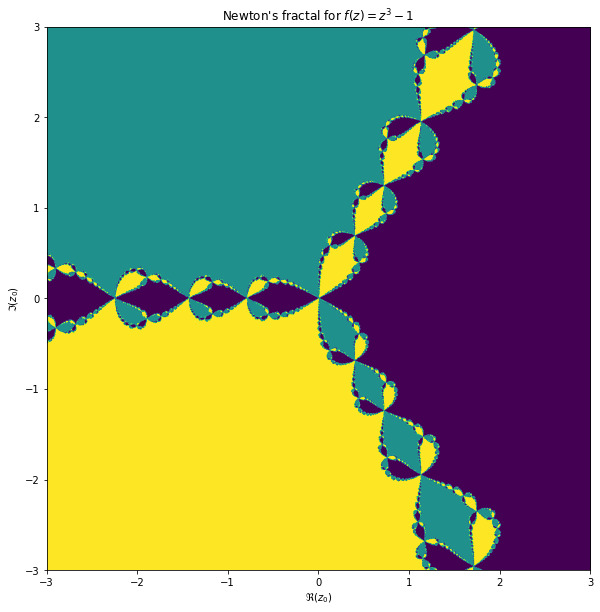

In [9]:
import matplotlib.pyplot as plt

exact_roots = np.array([1, -0.5 + np.sqrt(3)/2*1j, -0.5 - np.sqrt(3)/2*1j])

Re = np.linspace(-3,3,1000)
Im = np.linspace(-3,3,1000)
X, Y = np.meshgrid(Re, Im)
Z = X + Y*1j

estimation = newton1d_new(F, DF, Z)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(r"Newton's fractal for $f(z)=z^3-1$")
ax.set_xlabel("$\Re(z_0)$")
ax.set_ylabel("$\Im(z_0)$")
ax.imshow(map_est_to_color(estimation, exact_roots), extent=[-3, 3, -3, 3], origin='lower')
plt.show()


**c)**
<span style="color:red">!</span> La méthode précédente a le désavantage de procéder séquentiellement au calcul pour chaque valeur de $z_0$, ce qui rend cette évaluation assez lente. Proposer une nouvelle implémentation permettant de calculer parallèlement toutes les valeurs de $z_0$ en utilisant les indexages Numpy.

<!-- --- begin hint in exercise --- -->

**Indication:**
Pour encore plus de rapidité, les itérations de Newton de $F(z)=z^3-1$ peuvent être calculées à la main:

$$
z_{n+1} = \frac{1}{3z_n^2} + \frac{2z_n}{3} \,.
$$

In [10]:
%%timeit
estimation = newton1d_new(F, DF, Z)  # The previous function

1.69 s ± 54.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


> __My functions above is pretty optimised in my opinion, as they utilise mostly Numpy's vectorised and universal functions (ufunc). For computation of 1 million values of $z_0$ (I used `np.linspace(-3,3,1000)` for each axis), of which each value is iterated some number of times until the approximation is below the tolerated error, the computation time is only 1.69 second on an iMac with a core i5 @3.1 Ghz. This is impressive, Numpy, not me.__



<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

# Exercise 7.4: <span style="color:red">!!</span> Non-linear differential equations
<div id="exer:newton-nonlinear"></div>

The goal is to solve for the following differential equation, with some initial conditions:

$$
\begin{align*}
u^{\prime\prime}(x)+u^{3}(x) & = \sin(x) \,, & u(0) & = u(2\pi) = 0 \,,
\end{align*}
$$

on the interval $[0,2\pi]$. This equation is a simplified model of a non-linear Schröndinger's equation

The method used is the finite differences which include searching for the values of $u$ at points $x_n = \frac{2\pi n}{N}$ for $n=0,1,\dots,N$. The variables are then $u_n = u(x_n)$ which form a vector of $N+1$ dimensions. The finite differences method looks for approximating the second derivative by

$$
u^{\prime\prime}(x) \approx \frac{u(x+h)-2u(x)+u(x-h)}{h^{2}} \,,
$$

when $h$ is small.

By setting $h=\frac{2\pi}{N}$, we have:

$$
u^{\prime\prime}(x_n) \approx \frac{u_{n+1}-2u_n+u_{n-1}}{h^{2}} \,,
$$

then the initial equation can be approximated with:

$$
\begin{align*}
\frac{u_{n+1}-2u_{n}+u_{n-1}}{h^{2}}+u_{n}^{3} & = \sin(x_{n}) \,, & u_{0} & = u_{N} = 0 \,,
\end{align*}
$$

for $n=1,2,\dots,N-1$.

This equation can be seen as an equation of $F(u)=0$ for $u=(u_n)_ {n=0}^{N}$ which can be solved by Newton's method.

**a)**
Prove the following statement:

$$
u^{\prime\prime}(x) = \frac{u(x+h)-2u(x)+u(x-h)}{h^{2}} + O(h^2) \quad \text{when} \quad h \to 0 \,.
$$

<!-- --- begin hint in exercise --- -->

**Hints:**
Use the Taylor's theorem

<!-- --- end hint in exercise --- -->



> $$
\begin{align}
{}&   \lim_{h \rightarrow 0} \frac{u(x+h)-2u(x)+u(x-h)}{h^2}+O(h^2) \\
= {}& \lim_{h \rightarrow 0} {\dfrac{1}{h}\left[\dfrac{u\left(x+h\right)-u(x)}{h}-\dfrac{u(x)-u\left(x-h\right)}{h}\right]}+O(h^2) \\
= {}& \lim_{h \rightarrow 0} \frac{u'(x+h)-u'(x)}{h} + O(h^2) \\
= {}& u''(x)
\end{align}
$$



**b)**
Define a vector `x` representing the $N+1$ points equally distributed in $[0,1]$, and `h` the distance between the points, with a value of $N$ for example equal to 200.

In [11]:
N = 200
x = np.linspace(0, 2*np.pi, N+1)
h = 2*np.pi/N


**c)**
Define a function `F(u)` representing the function $F:\mathbb{R}^{N+1} \to \mathbb{R}^{N+1}$ which allow us to put the approximated equation under the form $F(u)=0$.
<!-- --- begin hint in exercise --- -->

**Hints:**
Use Numpy's slicing to execute faster.
<!-- --- end hint in exercise --- -->



In [12]:
def F(u):
    Fu = np.zeros_like(u)
    # We already know that u_0 = u_N = 0 therefore F(u_0) and F(u_N) can be calculated by hand and equal 0
    Fu[0] = u[0]
    Fu[-1] = u[-1]
    
    Fu[1:-1] = 1/h**2 * (-2*u[1:-1] + u[:N-1] + u[2:]) + u[1:-1]**3 - np.sin(x[1:-1])
    return Fu


**d)**
Define a function `DF(u)` representing the Jacobian matrix of the above function.
<!-- --- begin hint in exercise --- -->

**Hints:**
The Jacobian matrix is the derivative of $F(u)=F(u_0,u_1,\dots,u_N)$ for $u=(u_0,u_1,\dots,u_{N})$, meaning:

$$
F^{\prime}(u)=\begin{pmatrix}\partial_{0}F(u) & \partial_{1}F(u) & \partial_{2}F(u) & \cdots & \partial_{N-1}F(u) & \partial_{N}F(u)\end{pmatrix}\,,
$$

and can be calculated explicitly by hand.

<!-- --- end hint in exercise --- -->



In [13]:
def DF(u):
    # Since F(u_0) = u_0, dF(u_0)/du_0 = 1, the rest of the line is 0. Same goes for u_N
    DFu = np.eye(N+1)
    
    # Next step is to calculate the partial derivative of each F_n(u) that we defined above for n from 1 to N-1.
    # Each whole line in the Jacobian indeed only has 3 columns that have number, which is the (n-1), n, and (n+1)
    # columns, with n indicating the line's index from 1 to N-1. The values of these numbers correspond to the 
    # partial derivative of F_n for u_(n-1), u_n, and u_(n+1). Since the partial derivative for u_(n-1) and u_(n+1)
    # is equal to 1/h^2 for all n, we can carefully apply the diagonal matrix into our DFu matrix to obtain the correct
    # results without having to loop through every line. With the partial derivative for u_n, we apply the same method,
    # only different value
    DFu[1:-1,1:-1] *= (3*u[1:-1]**2 - 2/h**2)  # apply the partial derivative for each u_n
    
    m = np.eye(N-1)/h**2
    DFu[1:N,:N-1] += m  # partial derivative for each u_(n-1)
    DFu[1:N,2:] += m  # partial derivative for each u_(n+1)
    return DFu



**e)**
Use the function `newton` defined above to calculate an approximated solution of the equation. By changing the intial values, is it possible to find other solutions?
<!-- --- begin hint in exercise --- -->

**Indication:**
Try with the initial values $u_0(x) = (1+k)\sin(kx)$ for $k=1,2,3,4$ as starting point for Newton's method.

<!-- --- end hint in exercise --- -->



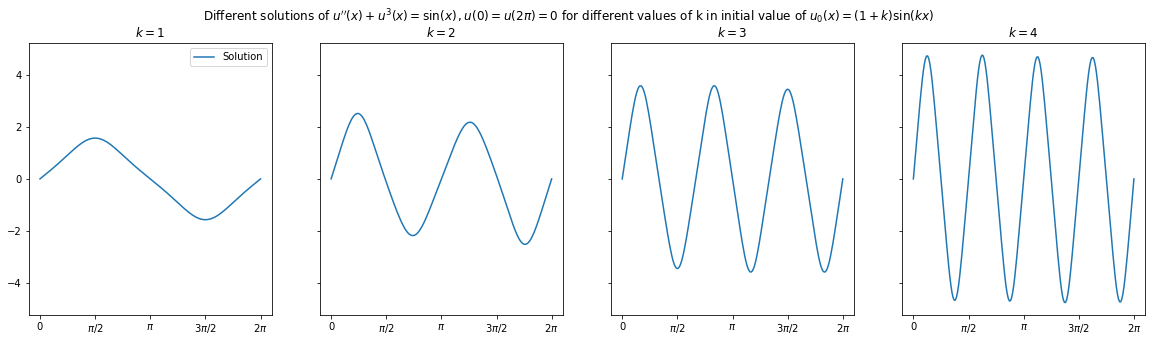

In [17]:
import matplotlib.pyplot as plt

k_ = range(1,5)

fig, ax_ = plt.subplots(1, 4, figsize=(20,5), sharey=True)

for k, ax in zip(k_, ax_):
    u0 = (1 + k)*np.sin(k*x)
    ax.plot(x, newton(F, DF, u0), label="Solution")
    ax.set_xticks(np.linspace(0,2*np.pi,5))
    ax.set_xticklabels(['0', r'$\pi /2$', r'$\pi$', r'$3\pi /2$', r'$2\pi$'])
    ax.set_title(f"$k={k}$")
    if k == 1:
        ax.legend()
plt.suptitle(r"Different solutions of $u^{\prime\prime}(x)+u^{3}(x)=\sin(x) \,, u(0)=u(2\pi) = 0$ for different values of k in initial value of $u_0(x) = (1+k)\sin(kx)$")
plt.show()

> __By setting different k, we see that the Newton's method approaches different solutions, each with its own amplitude and oscillation's frequency.__